In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from hiding_adversarial_attacks.manipulation.utils import get_similarities

import pandas as pd
import seaborn as sns
import torch

In [2]:
data_path = "/home/steffi/dev/master_thesis/hiding_adversarial_attacks/data/external"
mnist_path = os.path.join(data_path, "MNIST/processed")
fashion_mnist_path = os.path.join(data_path, "FashionMNIST/processed")
cifar10_path = os.path.join(data_path, "CIFAR10")

## DeepFool
adversarial_path = "/home/steffi/dev/master_thesis/hiding_adversarial_attacks/data/preprocessed/adversarial"
mnist_adv_path = os.path.join(adversarial_path, "data-set=MNIST--attack=DeepFool--eps=0.2--cp-run=HAA-946")
fashion_mnist_adv_path = os.path.join(adversarial_path, "data-set=FashionMNIST--attack=DeepFool--eps=0.105--cp-run=HAA-952")
cifar10_adv_path = os.path.join(adversarial_path, "data-set=CIFAR10--attack=DeepFool--eps=0.1--cp-run=HAA-943")

# GradCAM
mnist_expl_path_gradcam = os.path.join(mnist_adv_path, "exp=GradCAM--l=conv2--ra=False")
fashion_mnist_path_gradcam = os.path.join(fashion_mnist_adv_path, "exp=GradCAM--l=conv2--ra=False")
cifar10_path_gradcam = os.path.join(cifar10_adv_path, "exp=GradCAM--l=model.features.18.0--ra=False")


## Load data

In [3]:
def load_explanations(data_set_path: str):
    train_expl_orig, train_labels_orig, _ = torch.load(os.path.join(data_set_path, "training_orig_exp.pt"))
    train_expl_adv, train_labels_adv, _ = torch.load(os.path.join(data_set_path, "training_adv_exp.pt"))
    return train_expl_orig, train_labels_orig, train_expl_adv, train_labels_adv

### Mapping FashionMNIST and CIFAR10

In [4]:
fashion_mnist_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

cifar10_mapping = {
    0: "Airplane",
    1: "Car",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

# GradCAM

In [5]:
# Explanations
mnist_train_expl_orig, mnist_train_label_orig, mnist_train_expl_adv, mnist_train_label_adv = load_explanations(mnist_expl_path_gradcam)
fashion_mnist_train_expl_orig, fashion_mnist_train_label_orig, fashion_mnist_train_expl_adv, fashion_mnist_train_label_adv = load_explanations(fashion_mnist_path_gradcam)
cifar10_train_expl_orig, cifar10_train_label_orig, cifar10_train_expl_adv, cifar10_train_label_adv = load_explanations(cifar10_path_gradcam)

In [6]:
reverse_mse, mnist_similarities_mse = get_similarities("MSE", mnist_train_expl_orig, mnist_train_expl_adv)
reverse_pcc, mnist_similarities_pcc = get_similarities("PCC", mnist_train_expl_orig, mnist_train_expl_adv)

reverse_mse, fashion_mnist_similarities_mse = get_similarities("MSE", fashion_mnist_train_expl_orig, fashion_mnist_train_expl_adv)
reverse_pcc, fashion_mnist_similarities_pcc = get_similarities("PCC", fashion_mnist_train_expl_orig, fashion_mnist_train_expl_adv)

reverse_mse, cifar10_similarities_mse = get_similarities("MSE", cifar10_train_expl_orig, cifar10_train_expl_adv)
reverse_pcc, cifar10_similarities_pcc = get_similarities("PCC", cifar10_train_expl_orig, cifar10_train_expl_adv)

/home/steffi/dev/master_thesis/hiding_adversarial_attacks/src/hiding_adversarial_attacks/manipulation/utils.py:265: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_sim_loss = vmap(similarity_loss)


In [7]:
mnist_sim = pd.DataFrame([mnist_similarities_mse.numpy(), mnist_similarities_pcc.numpy(), mnist_train_label_orig.numpy(), mnist_train_label_adv.numpy()], index=["mse_sim", "pcc_sim", "orig_label", "adv_label"]).T
mnist_sim["orig_label_name"] = mnist_sim["orig_label"].map({i: str(int(i)) for i in list(mnist_sim["orig_label"].unique())})

In [8]:
fashion_mnist_sim = pd.DataFrame([fashion_mnist_similarities_mse.numpy(), fashion_mnist_similarities_pcc.numpy(), fashion_mnist_train_label_orig.numpy(), fashion_mnist_train_label_adv.numpy()], index=["mse_sim", "pcc_sim", "orig_label", "adv_label"]).T
fashion_mnist_sim["orig_label_name"] = fashion_mnist_sim["orig_label"].map(fashion_mnist_mapping)

In [9]:
cifar10_sim = pd.DataFrame([cifar10_similarities_mse.numpy(), cifar10_similarities_pcc.numpy(), cifar10_train_label_orig.numpy(), cifar10_train_label_adv.numpy()], index=["mse_sim", "pcc_sim", "orig_label", "adv_label"]).T
cifar10_sim["orig_label_name"] = cifar10_sim["orig_label"].map(cifar10_mapping)

In [161]:
color_palette = sns.color_palette("BuPu")
print(color_palette[0])

(0.861683967704729, 0.91280276816609, 0.9497577854671281)


### Plotting function

In [107]:
def plot_similarities_histograms(group, x, title, means, log=True, color="purple"):
    fig, axes = plt.subplots(2,5, figsize=(15,8), sharex=True, sharey=True)
    for (label, g), ax, mean in zip(group, axes.flatten(), means):
        g.plot(kind='hist', x=x, ax=ax, title=label, color=color, log=log)
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()

In [318]:
def plot_similarities_kde_with_boxplot(group, x, title, means, log_x=False, log_y=False, ylim_factor=1.06):
    fig, axes = plt.subplots(5,2, figsize=(16,12), sharex=True, sharey=True)
    color_p = ["Wistia", "PuRd"]
    if x == "mse_sim":
        color_p = ["PuRd", "Wistia"]
    color_palette = sns.color_palette(color_p[0], 5)
    p = sns.color_palette(color_p[1], 1)
                         
    idx = 0
    for (label, g), ax, mean in zip(group, axes.flatten(), means):
        if log_x:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.set_title(label)
        ax2 = ax.twinx()
            
        ax = sns.histplot(g, ax=ax, palette=p, label=x)
        y_lim = int(ax.get_ylim()[1] * ylim_factor)
        ax.set(ylim=(-5, y_lim))
        sns.boxplot(data=g, x=x, ax=ax2, color=color_palette[2])
        ax2.set(ylim=(-5, 1))
        mean_l = ax2.axvline(mean, color=color_palette[3], linestyle='dashed', linewidth=5, label="mean")
        ax.legend(loc='lower left')
        
        
    #fig.legend(handles=[ax], labels=range(0, 11))
    #plt.legend(handles=[ mean_l])   
    fig.suptitle(title, fontsize=16)
   
    plt.tight_layout()

# Distribution plots for each data set's explanation similarities by metric

## MNIST

### MSE

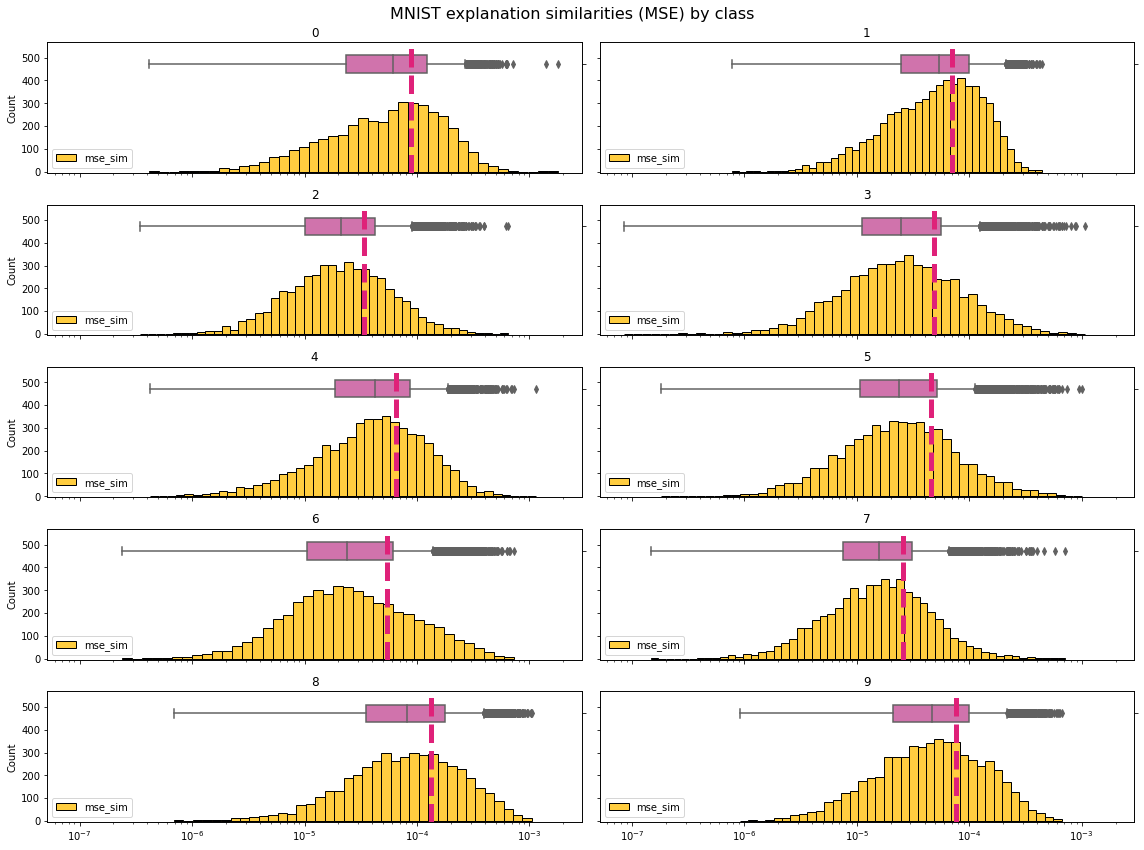

In [319]:
group = mnist_sim[["mse_sim", "orig_label_name"]].groupby("orig_label_name")
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "mse_sim", "MNIST explanation similarities (MSE) by class", means, log_x=True)

### Findings MNIST MSE (lower is better)
* Classes 2 and 7 seem to have the smallest spread with many similarities close to 0 => probably best to attack
* Class 8 has the largest spread and the least samples close to 0

### PCC

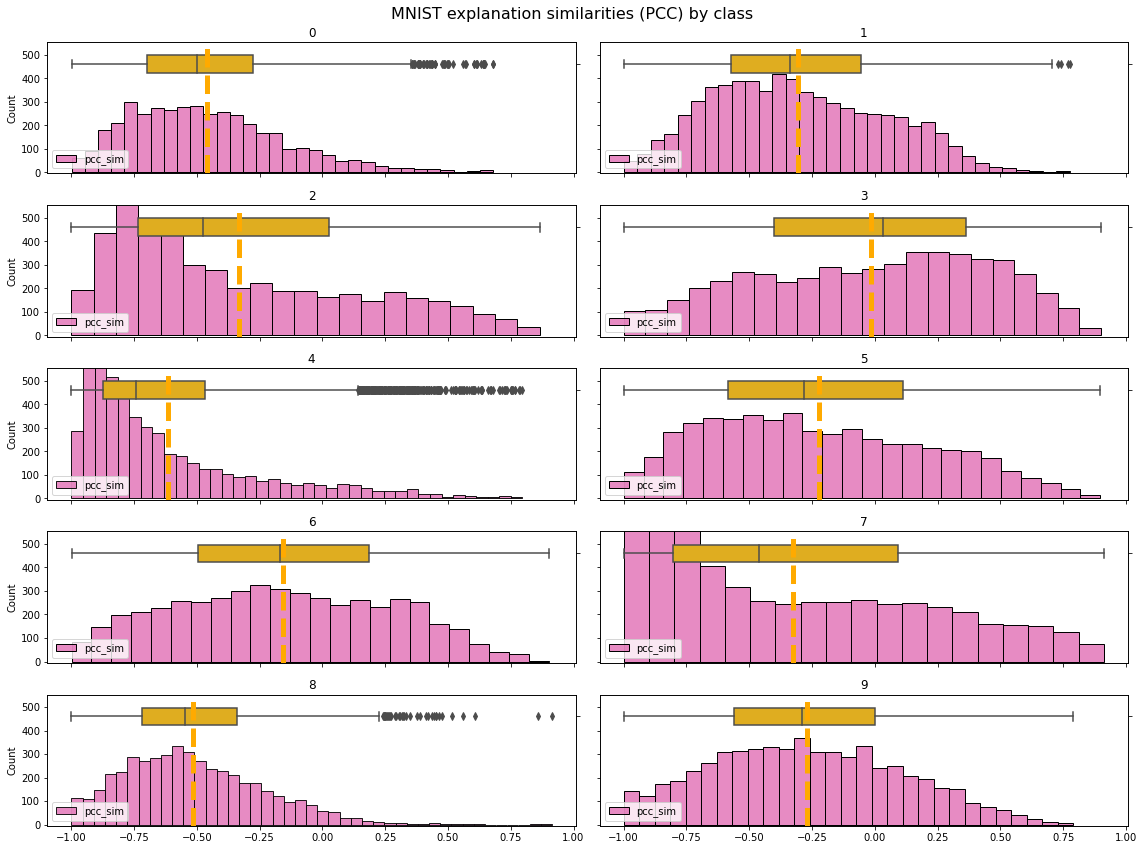

In [320]:
group = mnist_sim[["pcc_sim", "orig_label_name"]].groupby("orig_label_name")
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "pcc_sim", "MNIST explanation similarities (PCC) by class", means, log_x=False)

### Findings MNIST PCC (higher is better)
* Classes 3 and 6 have the least < 0 plus largest amount of samples > 0.5 => easiest to manipulate
* Classes 0, 4 (very bad), 7 and 8 have large amount < 0 => hardest to manipulate probably

## FashionMNIST

### MSE

In [337]:
fashion_mnist_sim.sort_values(by="orig_label")[["mse_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)

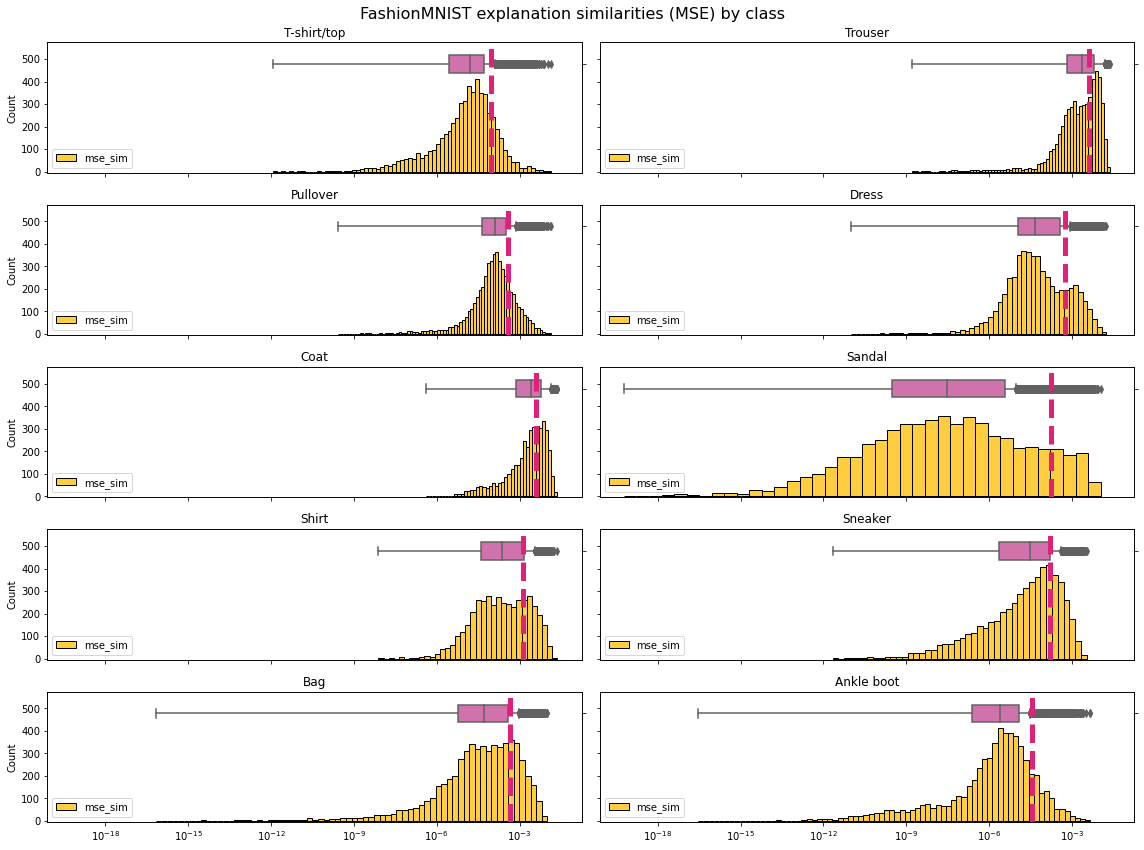

In [338]:
group = fashion_mnist_sim.sort_values(by="orig_label")[["mse_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "mse_sim", "FashionMNIST explanation similarities (MSE) by class", means, log_x=True, ylim_factor=1.03)

### Findings FashionMNIST MSE (lower is better)
* Classes Sneaker (7) and especially Ankle Boot (9) have the lowest spread and many close to 0 => easiest to manipulate?
* T-Shirt (0) and Sandal (5) also look okay
* Classes Trousers (1), Coat (4) and Shirt (6) have the largest spread

### PCC

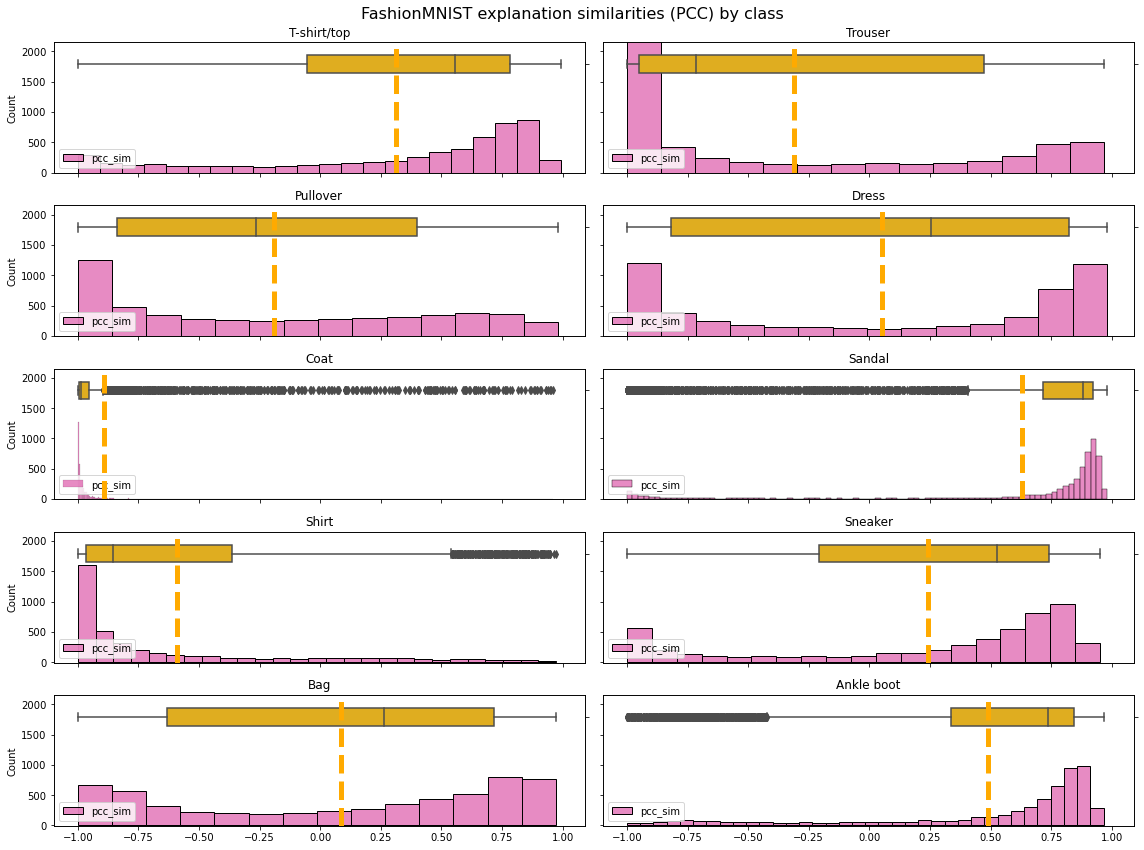

In [339]:
group = fashion_mnist_sim.sort_values(by="orig_label")[["pcc_sim", "orig_label_name"]].groupby("orig_label_name", sort=False)
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "pcc_sim", "FashionMNIST explanation similarities (PCC) by class", means, log_x=False, ylim_factor=1.09)

### Findings FashionMNIST PCC (higher is better)
* Sandal (5) (very good), Ankle Boot (9) and Sneaker (7) look promising with many > 0.5 => possibly easy to manipulate
* Coat (4) (very bad), Trouser (1) and Shirt (6) have many < 0 => hard to manipulate

## CIFAR10

### MSE

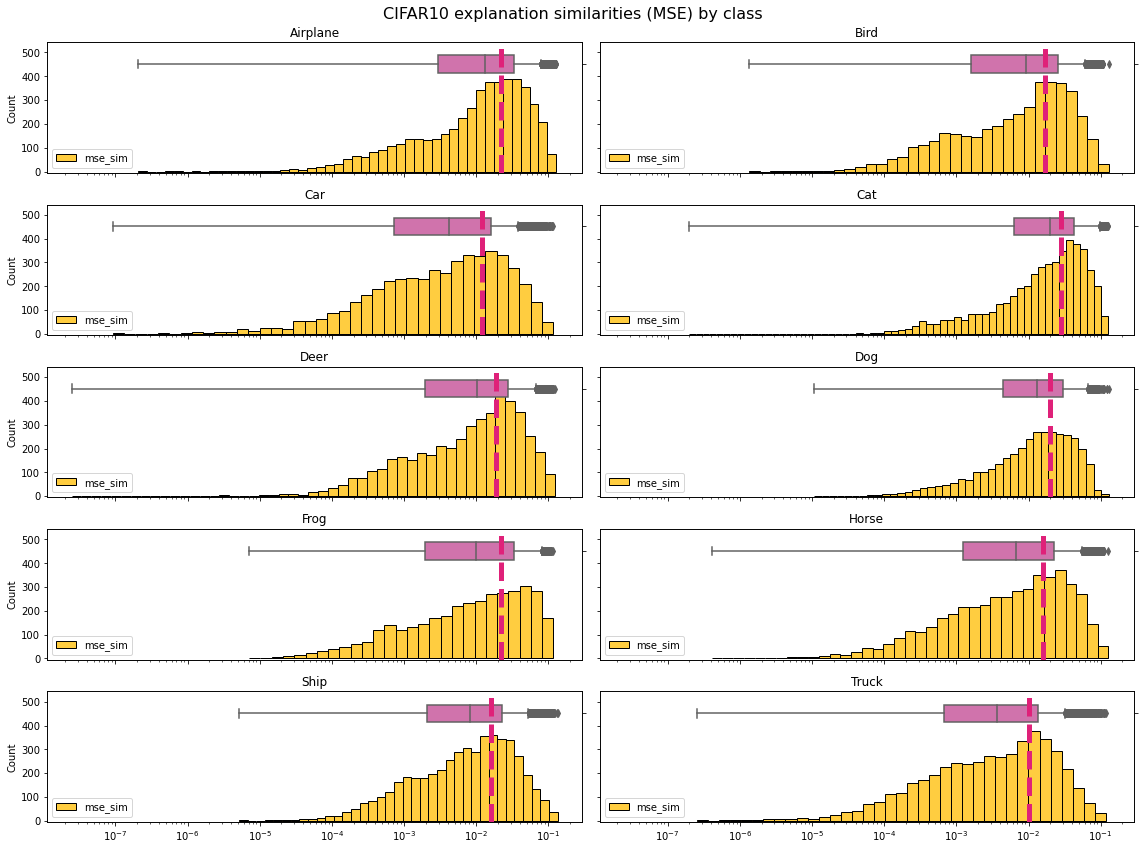

In [340]:
group = cifar10_sim.sort_values(by="orig_label")[["mse_sim", "orig_label_name"]].groupby("orig_label_name")
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "mse_sim", "CIFAR10 explanation similarities (MSE) by class", means, log_x=True, ylim_factor=1.03)

### Findings CIFAR10 MSE (lower is better)
* Car (1) and Truck (9) have most values very close to 0 => easiest?
* The distributions look pretty similar, similar spread of values

### PCC

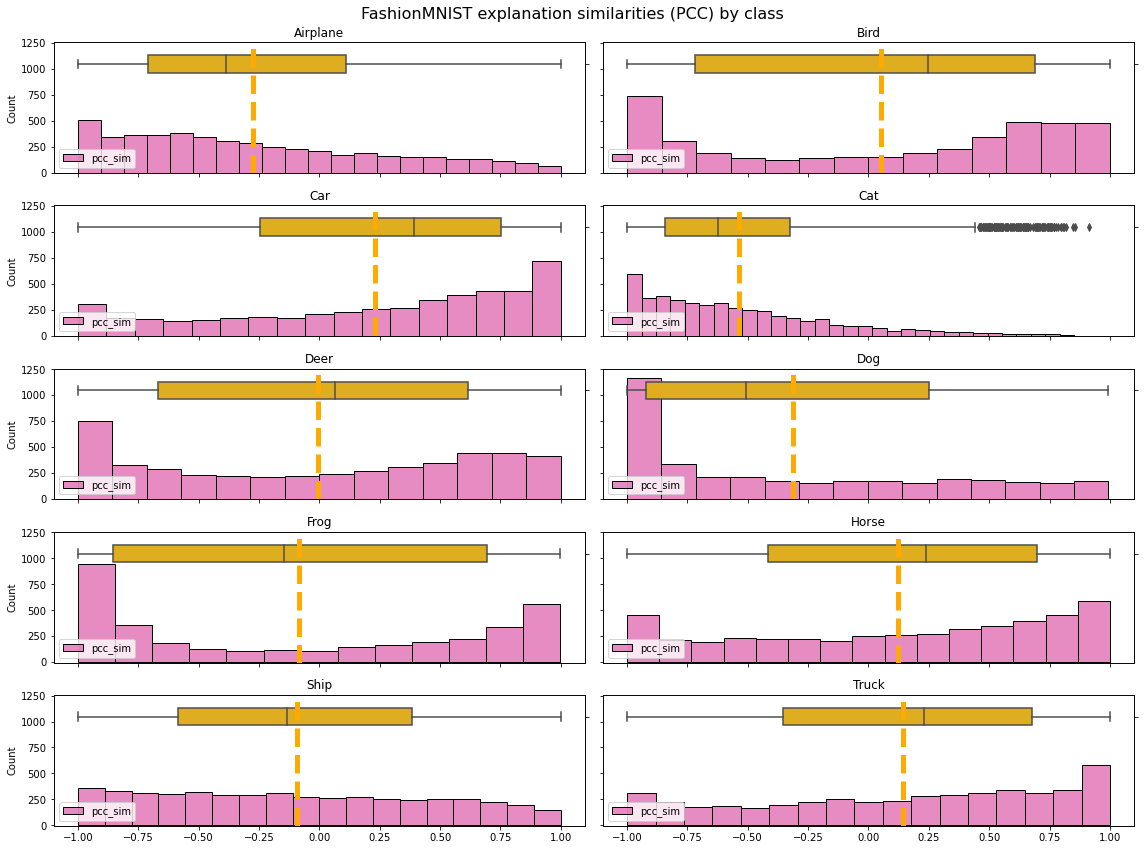

In [341]:
group = cifar10_sim.sort_values(by="orig_label")[["pcc_sim", "orig_label_name"]].groupby("orig_label_name")
means = group.mean().values.flatten()

plot_similarities_kde_with_boxplot(group, "pcc_sim", "FashionMNIST explanation similarities (PCC) by class", means, log_x=False, ylim_factor=1.09)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=False)


### Findings CIFAR10 PCC (higher is better)
* Car (1) (very good), Horse (7) and Truck (9) look promising with many > 0.5 and close to 1
* Unpromising: Dog (5), Airplane (0), Cat (3), Frog (6)